# dbt Cloud Project and Job Model Build Analysis Notebook

### This Python notebook leverages the robust dbt Cloud APIs to give in-depth analysis on what projects and jobs are producing dbt Cloud model builds
- The goal of this notebook is to provide a template for users to do analysis on their dbt Cloud projects and then alter said analysis into a way that makes sense for their org

Helpful docs:
- [dbt Cloud API Docs](https://docs.getdbt.com/docs/dbt-cloud-apis/overview)
- [dbt Cloud API SDK (dbtc)](https://dbtc.dpguthrie.com/0.4/)

### Importing packages

In [192]:
import pandas as pd
from dbtc import dbtCloudClient
import requests
import json
import math
import matplotlib.pyplot as plt

### define dbt Cloud account info and make connection

In [193]:
# set dbt cloud service toke
dbt_cloud_service_token = '<< USE dbt cloud Service Token >>'

# set dbt cloud account id
account_id = 12345

# create connection 
dbt_cloud_client = dbtCloudClient(service_token=dbt_cloud_service_token)

### Creating some lightweight functions to produce dataframe of number of model runs

In [200]:
# creating some dataframe tansformation functions

# a function to get all models for a given run
def get_models_for_job_run(run_row):

    gql_query = f'''{{
        job(id: {run_row['job_definition_id']} , runId: {run_row['id']}) {{
            models{{ name }}
            }}
        }}'''
    
    models_num = dbt_cloud_client.metadata.query(query)

    models_num_list = models_num['data']['job']['models']

    return models_num_list


# a function to count all models in a given run
def cnt_models_for_job_run(run_row):

    return len(run_row['models_in_run'])


# function to figure out how many runs need to be pulled
def get_runs_upper_limit(account_id, number_of_runs_to_return, project_id=None, job_id=None ):

    # get the run of runs for the query
    account_runs_upper = dbt_cloud_client.cloud.list_runs(account_id, project_id=project_id, job_definition_id=job_id, order_by='-finished_at', limit=1)['extra']['pagination']['total_count']

    # get the number of times we'll need to paginate
    number_of_offsets = (number_of_runs_to_return/100) if number_of_runs_to_return < account_runs_upper else (account_runs_upper/100)

    print(account_runs_upper, number_of_offsets)

    # number of offsets uniform
    number_of_offsets_uni = math.ceil(number_of_offsets)

    # final offset limit 
    final_limit_num = number_of_runs_to_return - ((number_of_offsets_uni-1) * 100)

    # return the number of offsets
    return {"offsets" : number_of_offsets_uni, "final_limit" : final_limit_num}


# creating a function that will get models for runs for the account level, project level, and job level
def gather_model_run_info_for_account_df(account_id, offset_num, limit=100, project_id=None, job_id=None, order_by='desc'):

    # define how we order the returned results
    order_results_by = '-finished_at' if order_by == 'desc' else 'finished_at'

    # return the requested runs
    run_info = dbt_cloud_client.cloud.list_runs(account_id, project_id=project_id, job_definition_id=job_id, order_by=order_results_by, offset=offset_num, limit=limit)['data']

    # turn the results into a dataframe
    run_info_df = pd.DataFrame.from_dict(run_info)[["id", "project_id", "job_definition_id", "finished_at", "is_complete", "is_success"]]

    # return the dataframe
    return run_info_df



# creating a function to get the proper number of results, turn the into a df, and union them
def turn_run_results_into_consolidated_df(account_id, number_of_runs_to_return, project_id=None, job_id=None, order_by='desc'):
    
    # getting the number_of_offsets required for what is needed
    offset_info = get_runs_upper_limit(account_id=account_id, project_id=project_id, job_id=job_id, number_of_runs_to_return=number_of_runs_to_return)

    # offset range
    offset_range = range(offset_info['offsets'])

    # looping thru and getting data into a single dataframe

    for intr in offset_range:

        # get first cut of dataframe
        if intr == 0 and intr != max(offset_range):

            # get the first runs df
            runs_df = gather_model_run_info_for_account_df(account_id, offset_num=0, project_id=project_id, job_id=job_id, order_by=order_by)


        elif intr == 0 and intr == max(offset_range):

             # get the first runs df
            runs_df = gather_model_run_info_for_account_df(account_id, offset_num=0, limit=offset_info['final_limit'], project_id=project_id, job_id=job_id, order_by=order_by)

        elif intr > 0 and intr != max(offset_range): 

            # getting next runs df
            runs_df_union = gather_model_run_info_for_account_df(account_id, offset_num=(intr*100), project_id=project_id, job_id=job_id, order_by=order_by)

            # union into first runs df
            runs_df = pd.concat([runs_df, runs_df_union])

        else:

             # getting next runs df
            runs_df_union = gather_model_run_info_for_account_df(account_id, offset_num=(intr*100), project_id=project_id, job_id=job_id, order_by=order_by)

            # union to first runs df
            runs_df = pd.concat([runs_df, runs_df_union])

    # filter to make sure we only look at completed and sucessful runs
    cleaned_runs_df = runs_df.query('is_complete == True & is_success == True')

    # return the final result
    return cleaned_runs_df


# # creating a function to take the fun run results and add additonal model information
def add_models_and_counts_into_df(runs_df):

    # apply the getting models to df
    runs_df['models_in_run'] = runs_df.apply(get_models_for_job_run, axis=1)

    # adding a count of models 
    runs_df['cnt_models_for_job_run'] = runs_df.apply(cnt_models_for_job_run, axis=1)

    # return the results
    return runs_df


# creating a function to pull it all together (one function to make life easy)
def get_runs_for_a_dbt_cloud_account(account_id, number_of_runs_to_return, project_id=None, job_id=None, order_by='desc'):

    # getting the data for the data
    dbt_cloud_runs = turn_run_results_into_consolidated_df(account_id=account_id, number_of_runs_to_return=number_of_runs_to_return, project_id=project_id, job_id=job_id,  order_by='desc')

    # adding to the dataframe to get model info
    run_and_model_df = add_models_and_counts_into_df(dbt_cloud_runs)

    # return the df
    return run_and_model_df

### Doing analysis of model builds at the account level

In [151]:
# getting the last 300 runs for the cloud account
# note this will take a little since we are making a few API calls
dfa = get_runs_for_a_dbt_cloud_account(account_id=account_id, number_of_runs_to_return=300)

# display the data to get a look at it
display(dfa)

,id,project_id,job_definition_id,finished_at,is_complete,is_success,models_in_run,cnt_models_for_job_run
0,215155814,131392,211981,2023-11-10 16:12:17.057721+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
1,215141032,131392,106102,2023-11-10 15:25:13.333972+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
2,213945231,131392,106102,2023-11-07 14:33:50.374886+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
3,213018699,131392,106102,2023-11-05 04:02:12.864145+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
4,212519303,131392,211981,2023-11-03 18:37:31.861498+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
...,...,...,...,...,...,...,...,...
94,92685839,131392,106102,2022-10-28 21:09:33.578786+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
95,92685837,131392,106102,2022-10-28 21:08:12.197860+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
96,92685836,131392,106102,2022-10-28 21:06:53.854049+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
97,92685835,131392,106102,2022-10-28 21:05:33.686707+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32


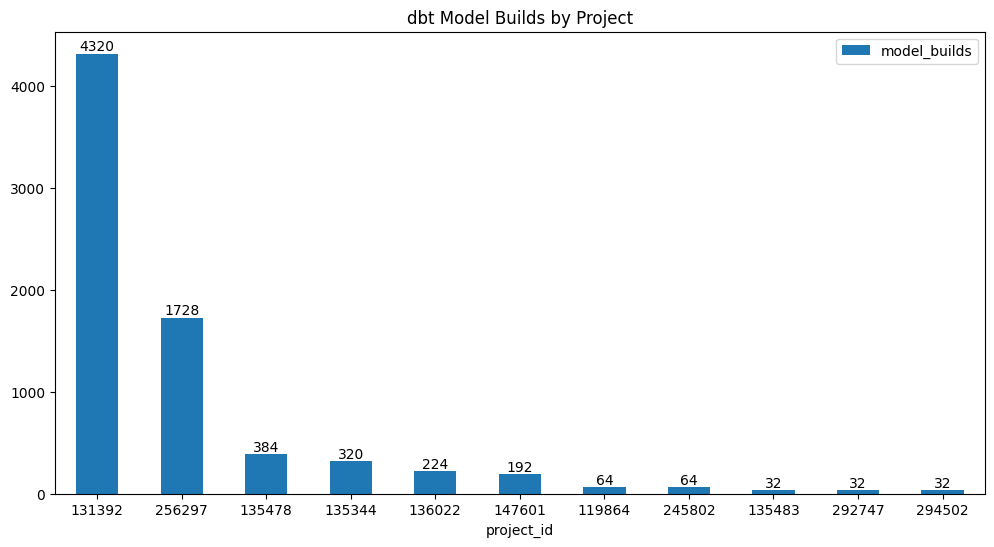

In [170]:
# grouping the data frame by project
project_model_builds = dfa[['project_id','cnt_models_for_job_run']].groupby(['project_id'], as_index=False).sum()

# rename the fields
project_model_builds.rename(columns={'cnt_models_for_job_run': 'model_builds'}, inplace=True)

# ordering them by desc
ordered_project_model_builds = project_model_builds.sort_values(by='model_builds', ascending=False)
 
# viz the data 
ax = ordered_project_model_builds.plot.bar(x='project_id', y='model_builds', rot=0, figsize=(12, 6), title="dbt Model Builds by Project")

# add data labels
for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')


# display the chart 
plt.show()

### Doing analysis of model builds at the project level

In [195]:
# getting the last 300 runs for the cloud account
# note this will take a little since we are making a few API calls
dfb = get_runs_for_a_dbt_cloud_account(account_id=account_id, project_id=131392, number_of_runs_to_return=300)

# display the data to get a look at it
display(dfb)

,id,project_id,job_definition_id,finished_at,is_complete,is_success,models_in_run,cnt_models_for_job_run
0,215155814,131392,211981,2023-11-10 16:12:17.057721+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
1,215141032,131392,106102,2023-11-10 15:25:13.333972+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
2,213945231,131392,106102,2023-11-07 14:33:50.374886+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
3,213018699,131392,106102,2023-11-05 04:02:12.864145+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
4,212519303,131392,211981,2023-11-03 18:37:31.861498+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
...,...,...,...,...,...,...,...,...
90,69405910,131392,106102,2022-07-18 23:28:25.600169+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
91,69404313,131392,106102,2022-07-18 23:06:08.314334+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
92,69396591,131392,106102,2022-07-18 22:10:52.576755+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
93,69392999,131392,106102,2022-07-18 22:01:21.197600+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32


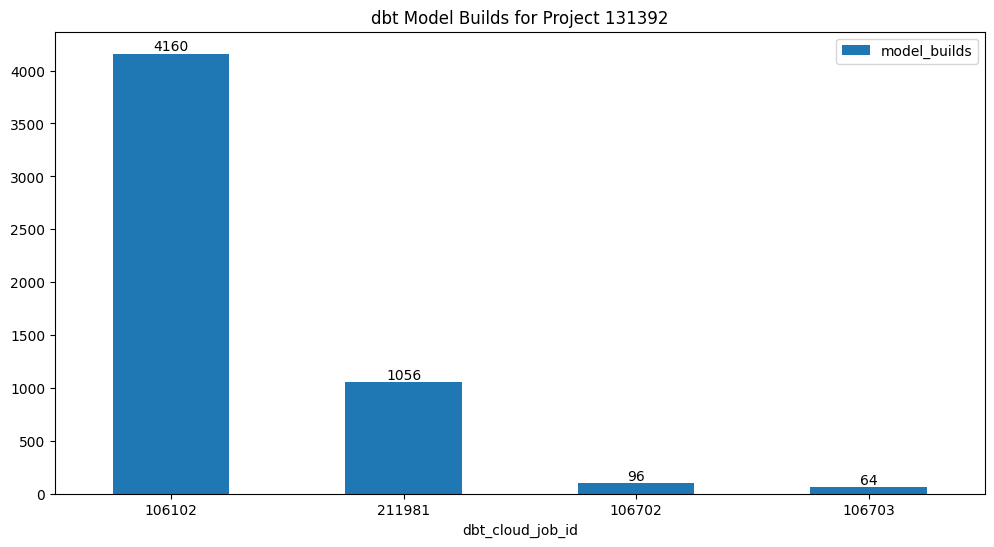

In [196]:
# grouping the data frame by project
project_model_builds = dfb[['job_definition_id','cnt_models_for_job_run']].groupby(['job_definition_id'], as_index=False).sum()

# rename the fields
project_model_builds.rename(columns={'cnt_models_for_job_run': 'model_builds', 'job_definition_id' : 'dbt_cloud_job_id'}, inplace=True)

# ordering them by desc
ordered_project_model_builds = project_model_builds.sort_values(by='model_builds', ascending=False)
 
# viz the data 
ax = ordered_project_model_builds.plot.bar(x='dbt_cloud_job_id', y='model_builds', 
                                           rot=0, figsize=(12, 6), title="dbt Model Builds for Project 131392")

# add data labels
for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')


# display the chart 
plt.show()

### Doing analysis of model builds at the job level

In [205]:
# getting the last 300 runs for the cloud account
# note this will take a little since we are making a few API calls
dfc = get_runs_for_a_dbt_cloud_account(account_id=account_id, project_id=131392, job_id=211981, number_of_runs_to_return=300)

# display the data to get a look at it
display(dfc)

42 0.42


,id,project_id,job_definition_id,finished_at,is_complete,is_success,models_in_run,cnt_models_for_job_run
0,215155814,131392,211981,2023-11-10 16:12:17.057721+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
1,212519303,131392,211981,2023-11-03 18:37:31.861498+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
2,209426263,131392,211981,2023-10-26 15:13:40.105909+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
3,209414933,131392,211981,2023-10-26 14:36:11.568577+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
4,209411206,131392,211981,2023-10-26 14:19:29.925653+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
5,209411013,131392,211981,2023-10-26 14:17:21.382364+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
9,204493656,131392,211981,2023-10-13 13:41:26.507221+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
11,203358928,131392,211981,2023-10-10 15:42:15.156583+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
12,203353133,131392,211981,2023-10-10 15:13:02.000942+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
13,201554352,131392,211981,2023-10-05 19:33:46.140911+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32


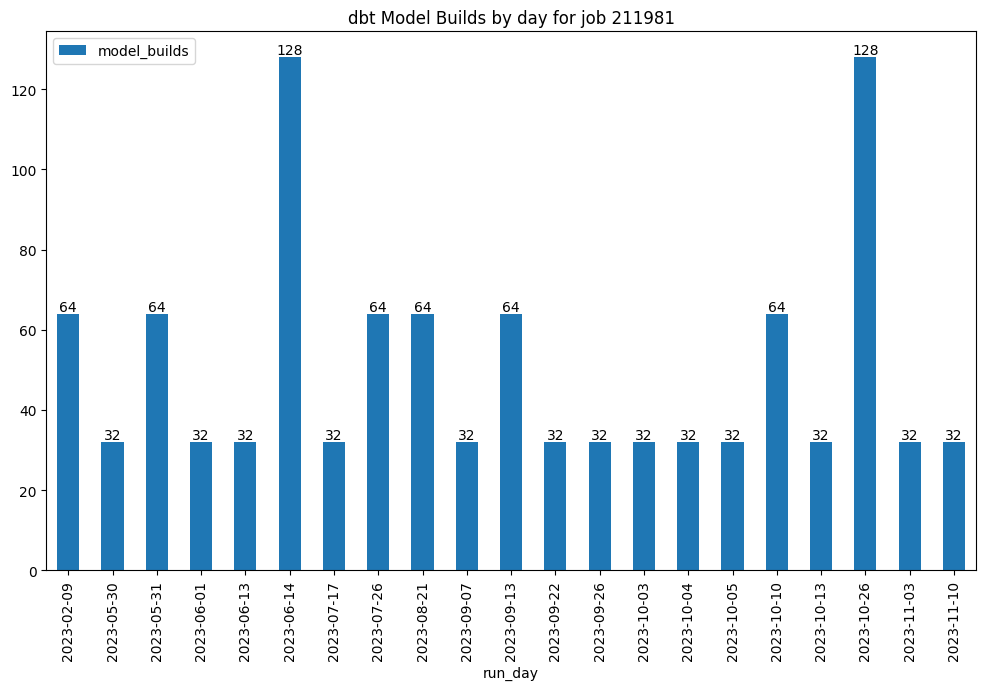

In [230]:
# adding a field that converts the timestamp column and truncates it
dfc['run_day'] = (pd.to_datetime(dfc['finished_at']).dt.floor('d')).dt.date

# grouping the data frame by day to make a time series
job_builds_by_date = dfc[['run_day','cnt_models_for_job_run']].groupby(['run_day'], as_index=False).sum()

# rename the fields
job_builds_by_date.rename(columns={'cnt_models_for_job_run': 'model_builds'}, inplace=True)

# ordering them by day
ordered_job_builds_by_date = job_builds_by_date.sort_values(by='run_day', ascending=True)


# viz the data 
ax = ordered_job_builds_by_date.plot.bar(x='run_day', y='model_builds', 
                                           rot=0, figsize=(12, 7), title="dbt Model Builds by day for job 211981")

# add data labels
for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
        
plt.xticks(rotation=90) 

plt.show()


___

# END OF SCRIPT
___